## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer as Imputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import xgboost as xgb
from xgboost import plot_importance
import time

### Preprocessing (normalization and padding values)

In [3]:
def data_processing():
    path = '../input/CICIDS2017sampled/CICIDS2017_sample.csv'
#     '../input/cicids2017-full-modified-all-8-files/combinenew.csv'
    df = pd.read_csv(path, skipinitialspace=True, low_memory=False)
    df.drop([len(df)-1],inplace=True)
    
    # 将主要的攻击类型分类
    df['Label'] = df['Label'].replace('DoS Hulk', 'DoS')
    df['Label'] = df['Label'].replace('DDoS', 'DoS')
    df['Label'] = df['Label'].replace('DoS GoldenEye', 'DoS')
    df['Label'] = df['Label'].replace('DoS slowloris', 'DoS')
    df['Label'] = df['Label'].replace('DoS Slowhttptest', 'DoS')
    df['Label'] = df['Label'].replace('Heartbleed', 'DoS')

    df['Label'] = df['Label'].replace('Web Attack_Brute Force', 'WebAttack')
    df['Label'] = df['Label'].replace('Web Attack_XSS', 'WebAttack')
    df['Label'] = df['Label'].replace('Web Attack_Sql Injection', 'WebAttack')

    df['Label'] = df['Label'].replace('FTP-Patator', 'BruteForce')
    df['Label'] = df['Label'].replace('SSH-Patator', 'BruteForce')
    
    # Min-max normalization
    numeric_features = df.dtypes[df.dtypes != 'object'].index
    df[numeric_features] = df[numeric_features].apply(
        lambda x: (x - x.min()) / (x.max()-x.min()))
    # Fill empty values by 0
    df = df.fillna(0)
    
    return df

In [4]:
df = data_processing()

In [5]:
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3.333333e-08,0.000144,0.000000,0.000013,0.000000,0.001327,0.003026,0.003114,0.002508,0.000000,...,0.333333,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,BENIGN
1,1.186475e-03,0.006494,0.006277,0.000462,0.004923,0.024401,0.000000,0.004849,0.015804,0.373453,...,0.333333,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,BENIGN
2,9.906083e-04,0.003175,0.002835,0.000408,0.002094,0.024401,0.000000,0.008555,0.022149,0.248968,...,0.533333,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,BENIGN
3,1.196475e-03,0.006061,0.005568,0.000454,0.004990,0.024401,0.000000,0.005093,0.016339,0.373453,...,0.333333,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,BENIGN
4,1.197875e-03,0.006927,0.005973,0.000464,0.005125,0.024401,0.000000,0.004572,0.015330,0.373453,...,0.333333,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56655,1.179017e-03,0.000433,0.000202,0.000117,0.000015,0.003596,0.042360,0.014139,0.000000,0.014271,...,0.333333,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,BENIGN
56656,1.950000e-06,0.000144,0.000202,0.000022,0.000011,0.001370,0.016137,0.005386,0.000000,0.009972,...,0.533333,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,BENIGN
56657,1.110733e-03,0.000144,0.000202,0.000033,0.000022,0.002012,0.023701,0.007911,0.000000,0.020719,...,0.533333,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,BENIGN
56658,9.589745e-02,0.000577,0.000405,0.000157,0.000164,0.019264,0.000000,0.015149,0.028548,0.303043,...,0.533333,0.000009,0.0,0.000009,0.000009,0.054652,0.0,0.054652,0.054652,DoS


### split train set and test set

In [6]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
X = df.drop(['Label'],axis=1).values 
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [7]:
X_train.shape

(45328, 77)

In [8]:
pd.Series(y_train).value_counts()

0    18185
3    15227
5     6357
2     2213
6     1744
1     1573
4       29
dtype: int64

### Oversampling by SMOTE

In [9]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={4:1500}) # Create 1500 samples for the minority class "4"

In [10]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [11]:
del smote

In [12]:
pd.Series(y_train).value_counts()

0    18185
3    15227
5     6357
2     2213
6     1744
1     1573
4     1500
dtype: int64

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

Accuracy of DT: 0.9954994705259442
Precision of DT: 0.9955315745581214
Recall of DT: 0.9954994705259442
F1-score of DT: 0.9955098376021184
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4546
           1       0.99      0.98      0.98       393
           2       0.99      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.62      0.71      0.67         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.99      0.99       436

    accuracy                           1.00     11332
   macro avg       0.94      0.95      0.95     11332
weighted avg       1.00      1.00      1.00     11332



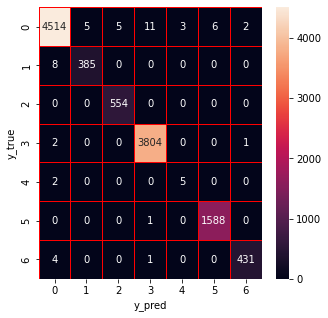

Time span of DT: 1.6249289512634277


In [13]:
# Decision tree training and prediction
start = time.time()

dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

end = time.time()
dt_span = end - start
print('Time span of DT: ' + str(dt_span))

In [14]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

Accuracy of RF: 0.9954994705259442
Precision of RF: 0.9955109609225063
Recall of RF: 0.9954994705259442
F1-score of RF: 0.9954865099474962
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4546
           1       0.96      0.97      0.97       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           1.00     11332
   macro avg       0.99      0.95      0.97     11332
weighted avg       1.00      1.00      1.00     11332



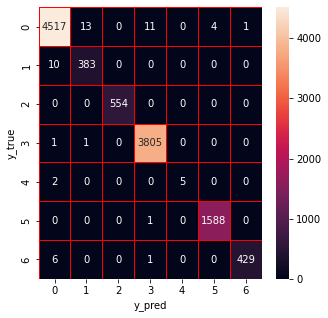

Time span of RF: 9.696107149124146


In [15]:
# Random Forest training and prediction
start = time.time()

rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

end = time.time()
rf_span = end - start
print('Time span of RF: ' + str(rf_span))

In [16]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

Accuracy of ET: 0.9923226261913166
Precision of ET: 0.9923247864810802
Recall of ET: 0.9923226261913166
F1-score of ET: 0.9923114472167227
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4546
           1       0.96      0.97      0.97       393
           2       0.99      1.00      0.99       554
           3       0.99      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       0.98      0.97      0.98       436

    accuracy                           0.99     11332
   macro avg       0.96      0.95      0.96     11332
weighted avg       0.99      0.99      0.99     11332



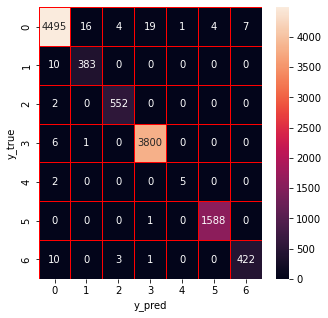

Time span of ET: 7.082869529724121


In [17]:
# Extra trees training and prediction
start = time.time()

et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

end = time.time()
et_span = end - start
print('Time span of ET: ' + str(et_span))

In [18]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

Accuracy of XGBoost: 0.9941757853865161
Precision of XGBoost: 0.994168114538626
Recall of XGBoost: 0.9941757853865161
F1-score of XGBoost: 0.9941591408148734
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4546
           1       0.99      0.97      0.98       393
           2       1.00      1.00      1.00       554
           3       0.99      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           0.99     11332
   macro avg       0.97      0.95      0.96     11332
weighted avg       0.99      0.99      0.99     11332



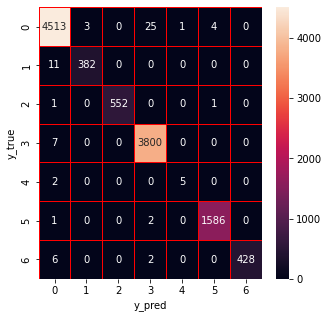

Time span of XGBoost: 7.94781756401062


In [19]:
# XGboost training and prediction
start = time.time()

xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

end = time.time()
xg_span = end - start
print('Time span of XGBoost: ' + str(xg_span))

In [20]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### Stacking model construction (ensemble for 4 base learners)

In [21]:
# Use the outputs of 4 base models to construct a new ensemble model
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,5,5,5,5
1,3,3,3,3
2,5,5,5,5
3,3,3,3,3
4,2,2,2,2


In [22]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [23]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

In [24]:
stk = xgb.XGBClassifier().fit(x_train, y_train)

Accuracy of Stacking: 0.9954994705259442
Precision of Stacking: 0.9955091865733592
Recall of Stacking: 0.9954994705259442
F1-score of Stacking: 0.9954831007745139
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4546
           1       0.99      0.98      0.98       393
           2       0.98      1.00      0.99       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.99      0.99       436

    accuracy                           1.00     11332
   macro avg       0.99      0.95      0.97     11332
weighted avg       1.00      1.00      1.00     11332



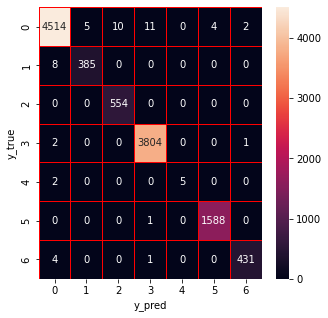

In [25]:
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [26]:
del X_train
del X_test
del y_train
del y_test

## Feature Selection

### Feature importance

In [27]:
# Save the feature importance lists generated by four tree-based algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xgb_feature = xg.feature_importances_

In [28]:
# calculate the average importance value of each feature
avg_feature = (dt_feature + rf_feature + et_feature + xgb_feature)/4

In [29]:
feature=(df.drop(['Label'],axis=1)).columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

Features sorted by their score:
[(0.1189, 'Bwd Packet Length Std'), (0.103, 'Bwd Packet Length Min'), (0.0601, 'Average Packet Size'), (0.0503, 'Init_Win_bytes_backward'), (0.0418, 'Init_Win_bytes_forward'), (0.036, 'PSH Flag Count'), (0.0346, 'Bwd Packets/s'), (0.0336, 'Avg Bwd Segment Size'), (0.0273, 'Bwd Packet Length Mean'), (0.0256, 'Packet Length Std'), (0.0229, 'Packet Length Mean'), (0.0211, 'Fwd Header Length.1'), (0.021, 'Bwd Header Length'), (0.0176, 'Total Length of Bwd Packets'), (0.0173, 'min_seg_size_forward'), (0.0173, 'Bwd Packet Length Max'), (0.0169, 'Fwd Header Length'), (0.0167, 'act_data_pkt_fwd'), (0.0163, 'Max Packet Length'), (0.0146, 'ACK Flag Count'), (0.0143, 'Packet Length Variance'), (0.0143, 'Min Packet Length'), (0.0132, 'Total Length of Fwd Packets'), (0.0111, 'Idle Max'), (0.0107, 'Total Fwd Packets'), (0.0107, 'Fwd IAT Max'), (0.0099, 'Fwd Packet Length Mean'), (0.0099, 'Fwd Packet Length Max'), (0.0098, 'Fwd IAT Mean'), (0.0093, 'URG Flag Count'), (

In [30]:
f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)

In [31]:
len(f_list)

77

In [32]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9:
        break        

In [33]:
X_fs = df[fs].values

In [34]:
del df # release memory

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_fs,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [36]:
X_train.shape

(45328, 40)

In [37]:
pd.Series(y_train).value_counts()

0    18185
3    15227
5     6357
2     2213
6     1744
1     1573
4       29
dtype: int64

### Oversampling by SMOTE

In [38]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={4:1500})

In [39]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [40]:
pd.Series(y_train).value_counts()

0    18185
3    15227
5     6357
2     2213
6     1744
1     1573
4     1500
dtype: int64

## Machine learning model training after feature selection

Accuracy of KNN: 0.9922343805153547
Precision of KNN: 0.992316813708562
Recall of KNN: 0.9922343805153547
F1-score of KNN: 0.9922671172996343
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4546
           1       0.97      0.96      0.96       393
           2       0.99      1.00      0.99       554
           3       1.00      1.00      1.00      3807
           4       0.44      0.57      0.50         7
           5       1.00      1.00      1.00      1589
           6       0.98      0.98      0.98       436

    accuracy                           0.99     11332
   macro avg       0.91      0.93      0.92     11332
weighted avg       0.99      0.99      0.99     11332



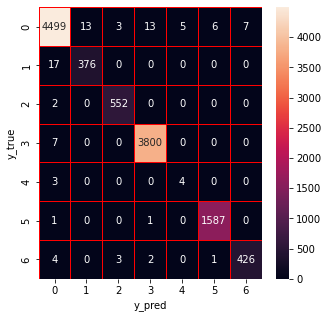

Time span of KNN: 19.72236680984497


In [41]:
# KNN training and prediction
start = time.time()

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
knn_score=knn.score(X_test,y_test)
y_predict=knn.predict(X_test)
y_true=y_test
print('Accuracy of KNN: '+ str(knn_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of KNN: '+(str(precision)))
print('Recall of KNN: '+(str(recall)))
print('F1-score of KNN: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


end = time.time()
knn_span = end - start
print('Time span of KNN: ' + str(knn_span))

Accuracy of SVM: 0.8587186727850336
Precision of SVM: 0.8644560786004941
Recall of SVM: 0.8587186727850336
F1-score of SVM: 0.844012596902354
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      4546
           1       1.00      0.03      0.05       393
           2       0.69      0.78      0.73       554
           3       0.88      0.95      0.91      3807
           4       0.33      0.29      0.31         7
           5       0.85      0.99      0.91      1589
           6       0.93      0.82      0.87       436

    accuracy                           0.86     11332
   macro avg       0.79      0.67      0.66     11332
weighted avg       0.86      0.86      0.84     11332



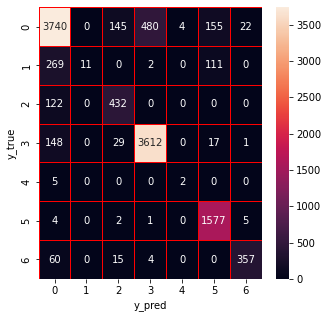

Time span of SVM: 126.18405055999756


In [42]:
start = time.time()

svm = svm.SVC(kernel='linear') # Linear Kernel
svm.fit(X_train, y_train)
svm_score=svm.score(X_test,y_test)
y_predict=svm.predict(X_test)
y_true=y_test
print('Accuracy of SVM: '+ str(svm_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of SVM: '+(str(precision)))
print('Recall of SVM: '+(str(recall)))
print('F1-score of SVM: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

end = time.time()
svm_span = end - start
print('Time span of SVM: ' + str(svm_span))

Accuracy of DT: 0.9958524532297918
Precision of DT: 0.9958507677958502
Recall of DT: 0.9958524532297918
F1-score of DT: 0.9958478099567875
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4546
           1       0.99      0.98      0.98       393
           2       0.99      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.86      0.86      0.86         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.98      0.99       436

    accuracy                           1.00     11332
   macro avg       0.97      0.97      0.97     11332
weighted avg       1.00      1.00      1.00     11332



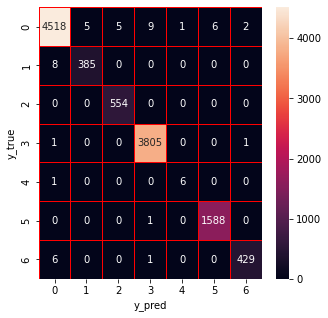

Time span of DT: 1.0762479305267334


In [43]:
# Decision tree training and prediction
start = time.time()

dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

end = time.time()
dt_span = end - start
print('Time span of DT: ' + str(dt_span))

In [44]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

Accuracy of RF: 0.9967349099894105
Precision of RF: 0.9967178570670523
Recall of RF: 0.9967349099894105
F1-score of RF: 0.9967203376747701
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4546
           1       0.99      0.98      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           1.00     11332
   macro avg       0.97      0.95      0.96     11332
weighted avg       1.00      1.00      1.00     11332



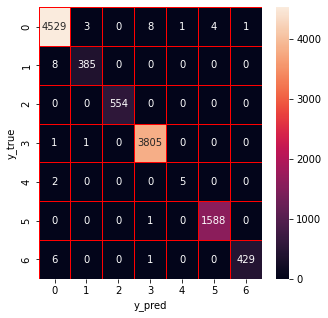

Time span of RF: 7.837737560272217


In [45]:
# Random Forest training and prediction
start = time.time()

rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

end = time.time()
rf_span = end - start
print('Time span of RF: ' + str(rf_span))

In [46]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

Accuracy of ET: 0.9954112248499823
Precision of ET: 0.9954232739578959
Recall of ET: 0.9954112248499823
F1-score of ET: 0.995398443528064
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4546
           1       0.97      0.98      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.99      0.99       436

    accuracy                           1.00     11332
   macro avg       0.99      0.95      0.97     11332
weighted avg       1.00      1.00      1.00     11332



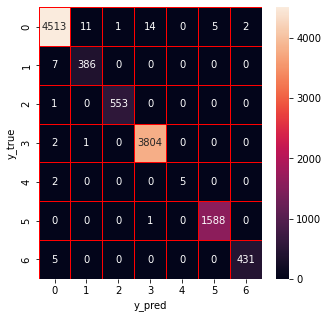

Time span of ET: 4.917617082595825


In [47]:
# Extra trees training and prediction
start = time.time()

et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

end = time.time()
et_span = end - start
print('Time span of ET: ' + str(et_span))

In [48]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

Accuracy of XGBoost: 0.9949699964701729
Precision of XGBoost: 0.9949617124693669
Recall of XGBoost: 0.9949699964701729
F1-score of XGBoost: 0.9949549887834711
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4546
           1       0.99      0.98      0.99       393
           2       1.00      1.00      1.00       554
           3       0.99      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           0.99     11332
   macro avg       0.97      0.95      0.96     11332
weighted avg       0.99      0.99      0.99     11332



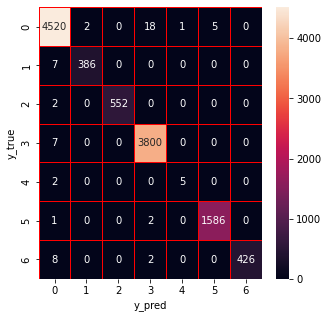

Time span of XGBoost: 4.582025527954102


In [49]:
# XGboost training and prediction
start = time.time()

xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

end = time.time()
xg_span = end - start
print('Time span of XGBoost: ' + str(xg_span))

In [50]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### Stacking model construction

In [51]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,5,5,5,5
1,3,3,3,3
2,5,5,5,5
3,3,3,3,3
4,2,2,2,2


In [52]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [53]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9953229791740205
Precision of Stacking: 0.9953290903861165
Recall of Stacking: 0.9953229791740205
F1-score of Stacking: 0.9952999611410367
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4546
           1       1.00      0.97      0.98       393
           2       0.99      1.00      1.00       554
           3       0.99      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           1.00     11332
   macro avg       1.00      0.95      0.97     11332
weighted avg       1.00      1.00      1.00     11332



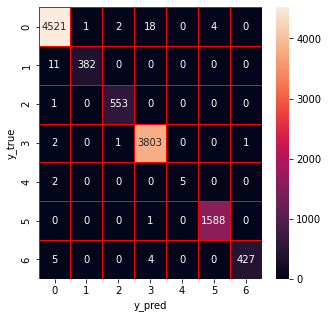

Time span of XGBoost: 2.781317949295044


In [54]:
start = time.time()

stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

end = time.time()
stk_span = end - start
print('Time span of XGBoost: ' + str(stk_span))